<a href="https://colab.research.google.com/github/Rohank12/fcc_cat_dog/blob/main/Kelley_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen variables`, use the `flow_from_directory` method. Pass in the batch size, directory, target size ((`IMG_HEIGHT`, `IMG_WIDTH`)), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.



In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        './cats_and_dogs/',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes=["test"],
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.

In [ ]:
# 5 TODO
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.5,
    width_shift_range=0.5,
    brightness_range=(0.5,1.5),
    zoom_range = [1, 1.5]
    )


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In this cell, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [ ]:
# 7
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
#model.add(MaxPooling2D((2,2)))

model.add(Flatten()) # need to flatten for dense
model.add(Dense(32, activation='relu'))
model.add(Dense(2))


model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_16 (Flatten)        (None, 147968)          

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

Idea for steps per epoch and validation steps comes from [this post](https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list)

In [ ]:
# 8
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=total_train//batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val//batch_size
)

Epoch 1/15
15/15 [==============================] - 24s 1s/step - loss: 0.9841 - accuracy: 0.4909 - val_loss: 0.6874 - val_accuracy: 0.5033
Epoch 2/15
15/15 [==============================] - 22s 1s/step - loss: 0.6941 - accuracy: 0.5188 - val_loss: 0.6916 - val_accuracy: 0.5368
Epoch 3/15
15/15 [==============================] - 22s 1s/step - loss: 0.6941 - accuracy: 0.5101 - val_loss: 0.6893 - val_accuracy: 0.5525
Epoch 4/15
15/15 [==============================] - 22s 1s/step - loss: 0.6915 - accuracy: 0.5187 - val_loss: 0.6883 - val_accuracy: 0.5022
Epoch 5/15
15/15 [==============================] - 22s 1s/step - loss: 0.6922 - accuracy: 0.5475 - val_loss: 0.6804 - val_accuracy: 0.5156
Epoch 6/15
15/15 [==============================] - 20s 1s/step - loss: 0.6918 - accuracy: 0.5470 - val_loss: 0.6848 - val_accuracy: 0.5759
Epoch 7/15
15/15 [==============================] - 21s 1s/step - loss: 0.6823 - accuracy: 0.5524 - val_loss: 0.6574 - val_accuracy: 0.5960
Epoch 8/15
15/15 [==

Run this cell to visualize the accuracy and loss of the model.

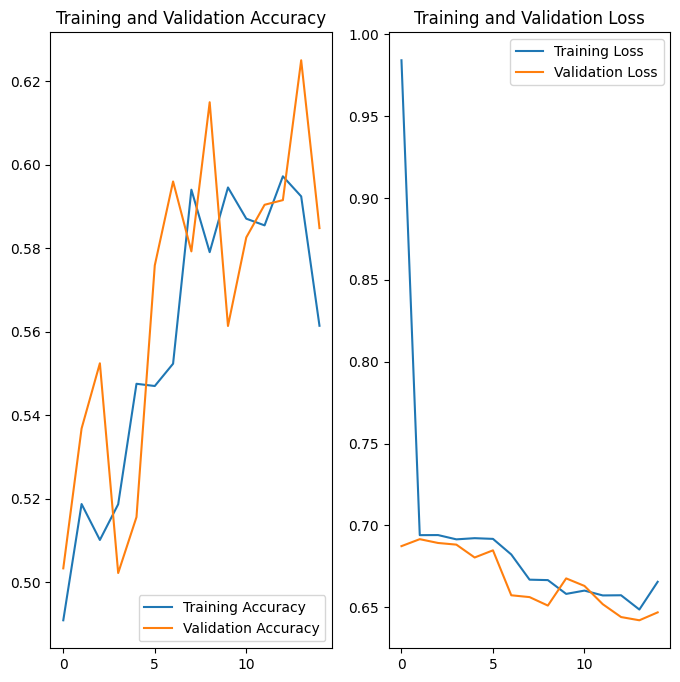

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 254ms/step


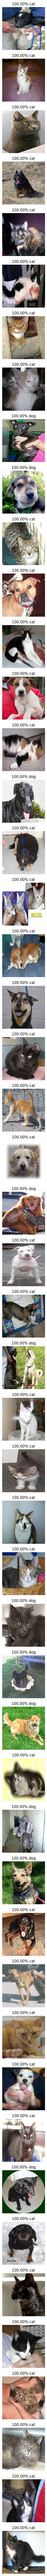

In [ ]:
sample_test_images, _ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(sample_test_images, probabilities)

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
